In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.fftpack
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

from sklearn import linear_model

from datetime import datetime

%matplotlib inline

In [2]:
energy_test = pd.read_csv('data/production_consumption_2017_scaled.csv', sep=';', decimal=',')
energy_test['timestamp'] = pd.to_datetime(energy_test['cet_cest_timestamp'])
energy_test.drop(['utc_timestamp', 'cet_cest_timestamp'], axis=1, inplace=True)
energy_test.set_index('timestamp', inplace=True)
energy_test.head()

,consumption,solarprod,windprod
timestamp,,,
2016-12-31 23:00:00,47.641,0.0,55.752072
2017-01-01 00:00:00,46.313,0.0,55.538781
2017-01-01 01:00:00,44.748,0.0,54.515708
2017-01-01 02:00:00,43.345,0.0,53.254038
2017-01-01 03:00:00,42.347,0.0,53.738461


In [3]:
energy_train = pd.read_csv('data/production_consumption_2012_2016_scaled.csv', sep=';', decimal=',')
energy_train['timestamp'] = pd.to_datetime(energy_train['cet_cest_timestamp'])
energy_train.drop(['utc_timestamp', 'cet_cest_timestamp'], axis=1, inplace=True)
energy_train.set_index('timestamp', inplace=True)
energy_train.head()

,consumption,solarprod,windprod
timestamp,,,
2011-12-31 23:00:00,40.318,0.0,16.542698
2012-01-01 00:00:00,38.406,0.0,17.609152
2012-01-01 01:00:00,36.501,0.0,19.554076
2012-01-01 02:00:00,35.305,0.0,22.030419
2012-01-01 03:00:00,34.568,0.0,24.344083


## Consumption Prediction

Train with 2016 and test with 2017

In [77]:
train = energy_train[energy_train.index >= datetime(2015,1,1)]['consumption']

In [78]:
test = energy_test[energy_test.index >= datetime(2017,1,1)]['consumption']

In [79]:
lag_acf = acf(train, nlags=24*7)
lag_pacf = pacf(train, nlags=24, method='ols')

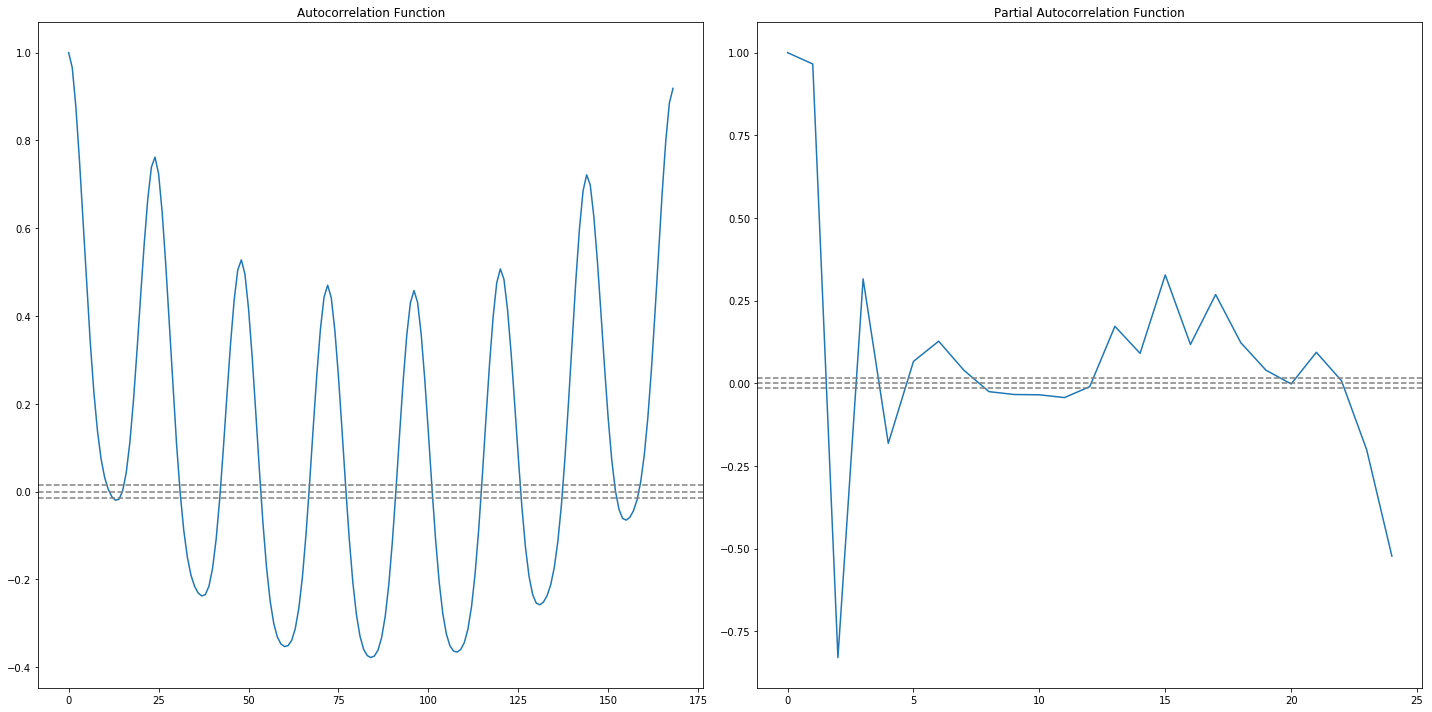

In [80]:
plt.figure(figsize=(20,10))
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [92]:
model = ARIMA(train, order=(5, 0, 2), freq='H')  
ARIMA_fitted = model.fit(disp=-1)  

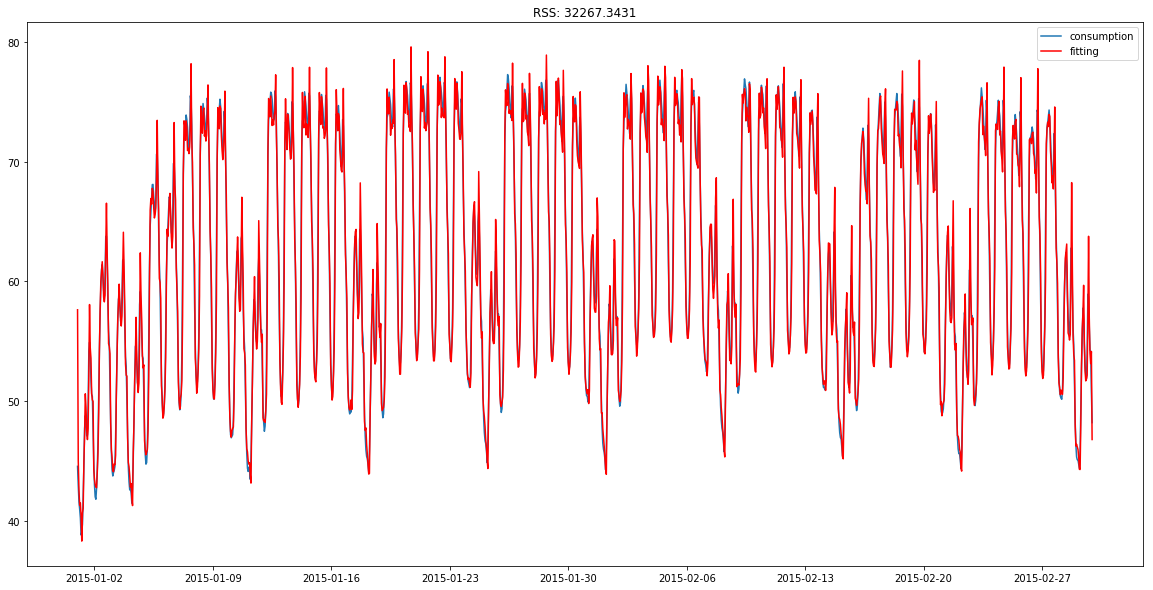

In [93]:
plt.figure(figsize=(20,10))
plt.plot(train[:60*24], label='consumption')
plt.plot(ARIMA_fitted.fittedvalues[:60*24], color='red', label='fitting')
plt.title('RSS: %.4f'% sum((ARIMA_fitted.fittedvalues-train)**2))
plt.legend()

In [85]:
len(ARIMA_fitted.fittedvalues)

17543

In [101]:
start_idx = len(train)
end_idx = start_idx + 24*7
prediction = ARIMA_fitted.predict(start=start_idx, end=end_idx)

In [102]:
len(prediction)

169

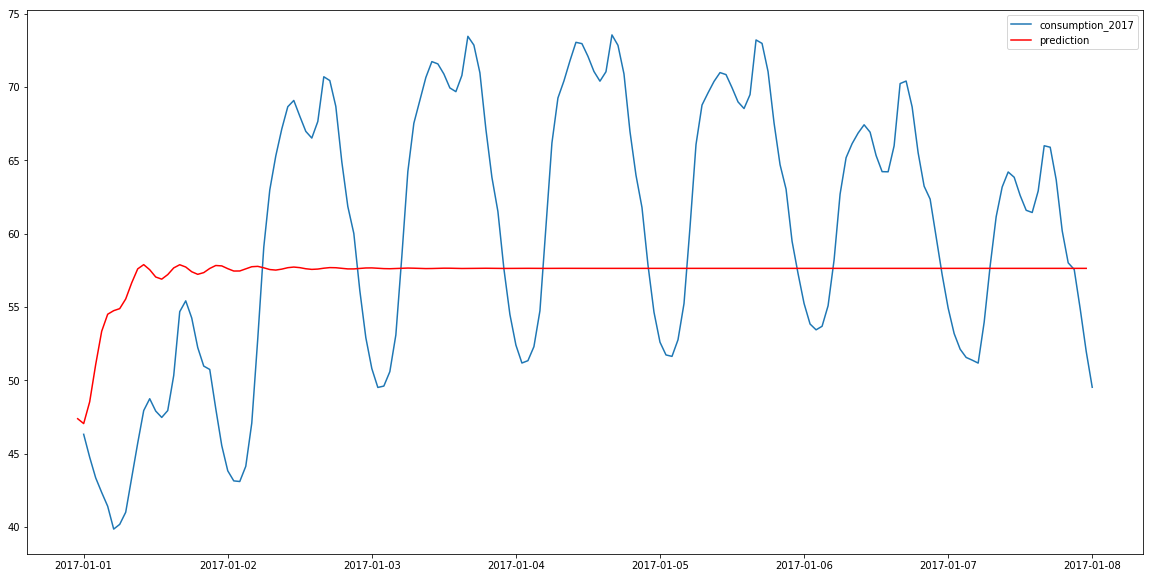

In [103]:
plt.figure(figsize=(20,10))
plt.plot(test[:169], label='consumption_2017')
plt.plot(prediction, color='red', label='prediction')
#plt.title('RSS: %.4f'% sum((prediction-test[:169])**2))
plt.legend()

## Weather-Production Correlation

In [111]:
weather = pd.read_csv('data/weather_UTC_2012-2016.csv', sep=';', decimal=',')

In [112]:
weather.VALUE_TIME = pd.to_datetime(weather.VALUE_TIME)
weather.set_index('VALUE_TIME', inplace=True)

In [128]:
w1 = weather[(weather.index>=datetime(2012, 1, 1)) & (weather.index < datetime(2016,12,31))]
w1.head()

,t_2m,precip_1h,global_rad,wind_speed_10m
VALUE_TIME,,,,
2012-01-01 00:00:00,3.3,0.05,0.0,12.2
2012-01-01 01:00:00,3.2,0.02,0.0,12.0
2012-01-01 02:00:00,3.1,0.02,0.0,11.7
2012-01-01 03:00:00,3.1,0.02,0.0,11.4
2012-01-01 04:00:00,3.7,0.02,0.0,11.9


In [131]:
e1 = energy_train[(energy_train.index >= datetime(2012,1,1)) & (energy_train.index < datetime(2016,12,31))]
e1.drop('consumption', axis=1, inplace=True)
e1.head()

c:\python27\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,solarprod,windprod
timestamp,,
2012-01-01 00:00:00,0.0,17.609152
2012-01-01 01:00:00,0.0,19.554076
2012-01-01 02:00:00,0.0,22.030419
2012-01-01 03:00:00,0.0,24.344083
2012-01-01 04:00:00,0.0,26.643287


In [132]:
w1.merge(e1, left_index=True, right_index=True).corr()

,t_2m,precip_1h,global_rad,wind_speed_10m,solarprod,windprod
t_2m,1.000000,0.048108,0.463769,-0.072143,0.433872,-0.147980
precip_1h,0.048108,1.000000,-0.031472,0.078672,0.002511,0.078957
global_rad,0.463769,-0.031472,1.000000,0.049170,0.928384,-0.147940
wind_speed_10m,-0.072143,0.078672,0.049170,1.000000,0.041040,0.627191
solarprod,0.433872,0.002511,0.928384,0.041040,1.000000,-0.129873
windprod,-0.147980,0.078957,-0.147940,0.627191,-0.129873,1.000000


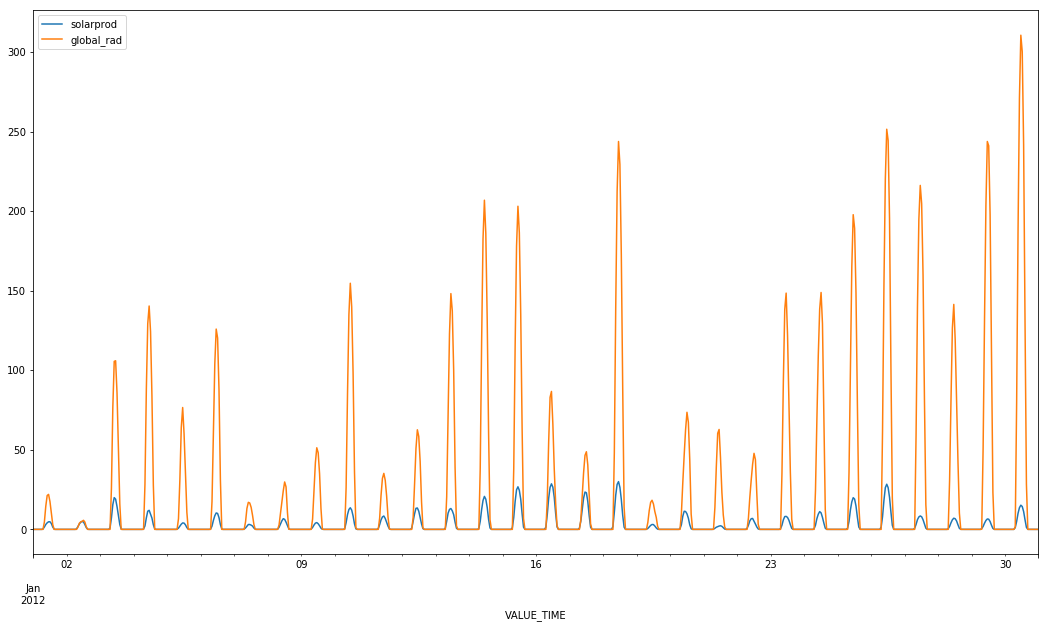

In [137]:
w1.merge(e1, left_index=True, right_index=True)[['solarprod', 'global_rad']][:30*24].plot(figsize=(18,10))
plt.legend()

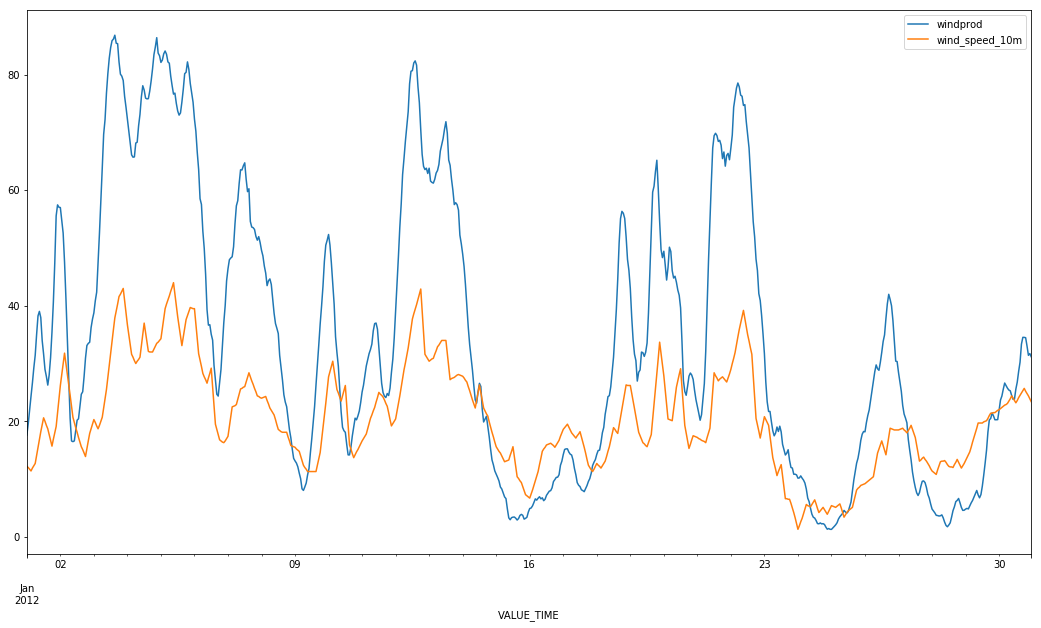

In [138]:
w1.merge(e1, left_index=True, right_index=True)[['windprod', 'wind_speed_10m']][:30*24].plot(figsize=(18,10))
plt.legend()

## Solar Power Prediction

In [165]:
w2 = pd.read_csv('data/weather_UTC_2017.csv', sep=';', decimal=',')

In [185]:
# Split the data into training/testing sets
x_train = np.array(w1[['wind_speed_10m','precip_1h', 't_2m']]) #[:-24*365*3]
x_test = np.array(w2[['wind_speed_10m','precip_1h', 't_2m']][:24*365])

# Split the targets into training/testing sets
y_train = np.array(e1['windprod']).reshape(-1,1)
y_test = np.array(energy_test['windprod'][:24*365]).reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [186]:
y_pred = regr.predict(x_test)

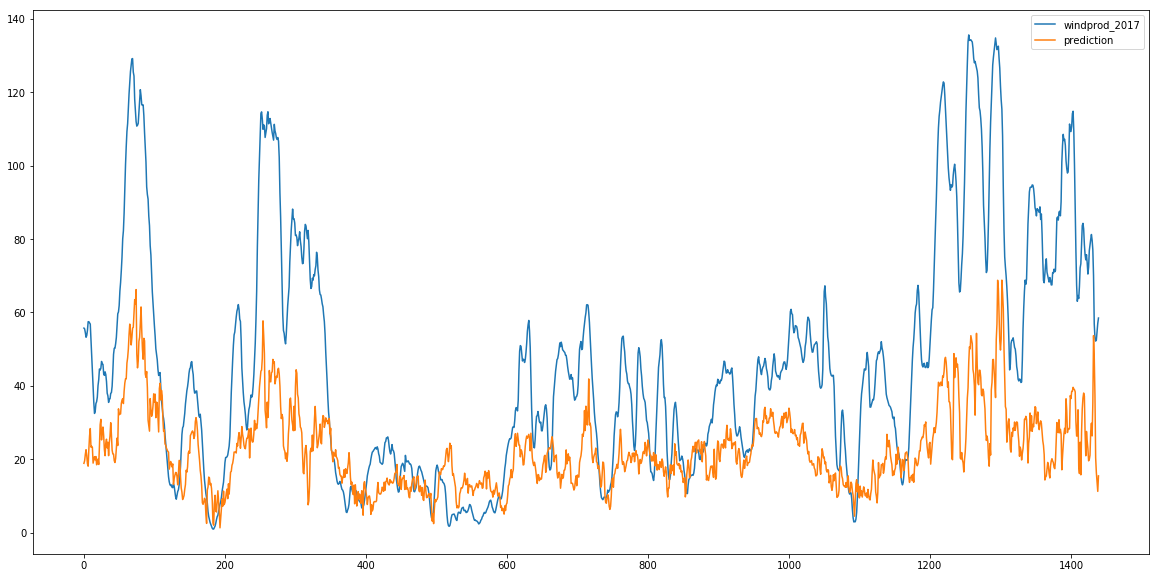

In [188]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:24*60], label='windprod_2017')
plt.plot(y_pred[:24*60], label='prediction')
plt.legend()

In [189]:
'RSS: {}'.format(sum((y_pred - y_test)**2))

'RSS: [ 9670447.67009245]'

## Wind Power Prediction

In [165]:
w2 = pd.read_csv('data/weather_UTC_2017.csv', sep=';', decimal=',')

In [190]:
# Split the data into training/testing sets
x_train = np.array(w1[['wind_speed_10m', 't_2m']]) #[:-24*365*3]
x_test = np.array(w2[['wind_speed_10m', 't_2m']][:24*365])

# Split the targets into training/testing sets
y_train = np.array(e1['windprod']).reshape(-1,1)
y_test = np.array(energy_test['windprod'][:24*365]).reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [191]:
y_pred = regr.predict(x_test)

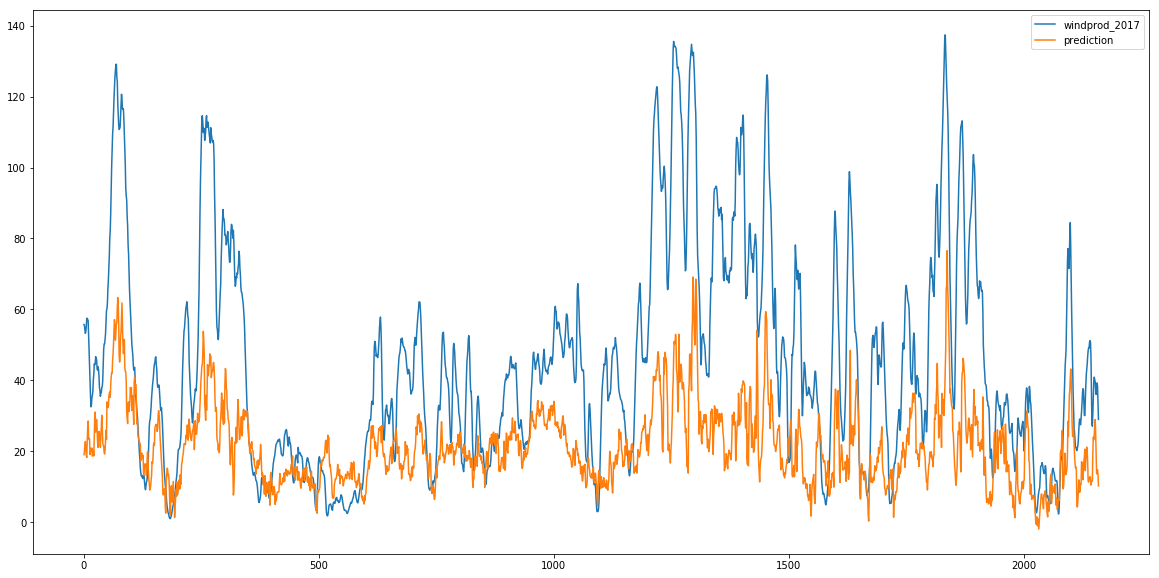

In [194]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:24*90], label='windprod_2017')
plt.plot(y_pred[:24*90], label='prediction')
plt.legend()

In [193]:
'RSS: {}'.format(sum((y_pred - y_test)**2))

'RSS: [ 9715920.22950006]'